<a href="https://colab.research.google.com/github/amr-elbana/EcoSortAI-Classifier/blob/main/notebooks/Augmented_waste_classification_Vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import keras,os
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Input, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# **DataSet**

In [6]:
from google.colab import drive
import zipfile
import os

# Mount Google Drive
drive.mount('/content/drive')

# Path to the zip file in Google Drive
zip_path = '/content/drive/MyDrive/DL_Project/waste_dataset.zip'

# Path to extract the contents
extract_path = '/content/drive/MyDrive/DL_Project/'

# Ensure the directory exists
os.makedirs(extract_path, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Files unzipped successfully!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import os
import random
import shutil

def move_unique_images_to_test(parent_dir, test_dir, move_percentage=0.2):
    """
    Moves a percentage of unique images from subfolders in the parent directory to a test directory.

    Args:
        parent_dir (str): Path to the parent directory containing subfolders of images.
        test_dir (str): Path to the test directory where images will be moved.
        move_percentage (float): The percentage of images to move (e.g., 0.2 for 20%).
    """
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)

    # Collect all unique images
    all_images = []
    for root, _, files in os.walk(parent_dir):
        image_files = [os.path.join(root, f) for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
        all_images.extend(image_files)

    # Determine how many images to move
    num_to_move = int(len(all_images) * move_percentage)
    images_to_move = random.sample(all_images, num_to_move)

    # Move images to test folder while maintaining subfolder structure
    for image_path in images_to_move:
        # Get relative path to maintain folder structure
        relative_path = os.path.relpath(image_path, parent_dir)
        destination_path = os.path.join(test_dir, relative_path)

        # Create destination folder if it doesn't exist
        os.makedirs(os.path.dirname(destination_path), exist_ok=True)

        # Move the image
        shutil.move(image_path, destination_path)
        print(f"Moved {image_path} to {destination_path}")

# Example usage
parent_directory = "/content/drive/MyDrive/DL_Project/waste_dataset"  # Replace with the path to your parent folder
test_directory = "/content/drive/MyDrive/DL_Project/waste_dataset-test"      # Replace with the path to your test folder

move_unique_images_to_test(parent_directory, test_directory)


Moved /content/drive/MyDrive/DL_Project/waste_dataset/recyclable/recyclable_010296_photo.jpg to /content/drive/MyDrive/DL_Project/waste_dataset-test/recyclable/recyclable_010296_photo.jpg
Moved /content/drive/MyDrive/DL_Project/waste_dataset/recyclable/recyclable_004238_photo.jpg to /content/drive/MyDrive/DL_Project/waste_dataset-test/recyclable/recyclable_004238_photo.jpg
Moved /content/drive/MyDrive/DL_Project/waste_dataset/recyclable/recyclable_007154_photo.jpg to /content/drive/MyDrive/DL_Project/waste_dataset-test/recyclable/recyclable_007154_photo.jpg
Moved /content/drive/MyDrive/DL_Project/waste_dataset/recyclable/recyclable_008049_photo.jpg to /content/drive/MyDrive/DL_Project/waste_dataset-test/recyclable/recyclable_008049_photo.jpg
Moved /content/drive/MyDrive/DL_Project/waste_dataset/recyclable/recyclable_010036_photo.jpg to /content/drive/MyDrive/DL_Project/waste_dataset-test/recyclable/recyclable_010036_photo.jpg
Moved /content/drive/MyDrive/DL_Project/waste_dataset/organi

In [8]:
# Define paths and constants
data_dir = "/content/drive/MyDrive/DL_Project/waste_dataset"
test_dir = "/content/drive/MyDrive/DL_Project/waste_dataset-test"
batch_size = 32
target_size = (224, 224)
epochs = 15

In [9]:
# Create an ImageDataGenerator with VGG16 preprocessing and data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # EfficientNetB2-specific preprocessing
    validation_split=0.2,  # Use 20% of data for validation
)

# Flow training data from the directory and apply preprocessing and augmentation
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=target_size,      # Resize images to EfficientNetB2 input size
    batch_size=batch_size,
    class_mode='binary',          # Binary classification
    subset='training',            # Use 80% of data for training
    seed=42,                      # Set seed for reproducibility
    shuffle=True                  # Shuffle the data to improve training
)

# Flow validation data from the directory and apply preprocessing (no augmentation for validation)
validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=target_size,      # Resize images to EfficientNetB2 input size
    batch_size=batch_size,
    class_mode='binary',          # Binary classification
    subset='validation',          # Use 20% of data for validation
    shuffle=False                 # No need to shuffle validation data
)

# # ... (rest of the code remains the same)

# Check the number of samples in each generator
print(f"Training samples: {train_generator.samples}")
# print(f"Validation samples: {validation_generator.samples}")
print(f"Training batches per epoch: {len(train_generator)}")
# print(f"Validation batches per epoch: {len(validation_generator)}")

Found 15812 images belonging to 2 classes.
Found 3952 images belonging to 2 classes.
Training samples: 15812
Training batches per epoch: 495


In [10]:
# Create an ImageDataGenerator for VGG16 preprocessing (no augmentation for the test set)
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input  # VGG16-specific preprocessing
)

# Flow data from the test directory and apply preprocessing
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # VGG16 input size
    batch_size=batch_size,
    class_mode='binary',     # Binary classification for the test set
    shuffle=False            # Do not shuffle test data to keep results consistent
)

# Check the number of samples in the test set
print(f"Test samples: {test_generator.samples}")
print(f"Test batches: {len(test_generator)}")

Found 4941 images belonging to 2 classes.
Test samples: 4941
Test batches: 155


# **Model Architecture**

In [11]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import SGD

def create_model():
   # Load VGG16 model with pretrained weights, excluding the top (fully connected) layers
    vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Build the model
    model = Sequential()
    for layer in vgg16_base.layers:
       model.add(layer)

# Freeze the layers of VGG16 to retain the pre-trained weights
    for layer in model.layers:
      layer.trainable = False # Not trainable weights

    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))  # L2 Regularization
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification

    model.summary()
    optimizer = SGD(learning_rate=0.0001, momentum=0.9)  # Lower learning rate
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])


    return model

# Create the model
model = create_model()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,203,521 (80.89 MB)

 Trainable params: 6,488,833 (24.75 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

# **Training**

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Define callbacks
checkpoint_path = "/content/drive/MyDrive/Final_DL_Project/Waste_vgg16_{epoch:02d}-{val_accuracy:0.2f}.keras"
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  # Save the best model based on validation accuracy
    verbose=1,
    save_best_only=True,
    mode='max'
)

early_stopping_monitor = EarlyStopping(
    monitor='val_loss',         # Focus on reducing overfitting
    patience=5,                # Allow enough time for gradual improvements
    restore_best_weights=True,  # Load the best weights after stopping
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Adjust learning rate if validation loss doesn't improve
    factor=0.2,          # Reduce learning rate by a factor of 5
    patience=2,          # Wait 5 epochs before reducing


    min_lr=1e-6,         # Set a minimum learning rate
    verbose=1
)

# Train the model with callbacks
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,  # Set a sufficiently high number; EarlyStopping will handle stopping
    callbacks=[checkpoint, early_stopping_monitor, reduce_lr]
)

# Save the final best model
model.save('/content/drive/MyDrive/Final_DL_Project/Waste_vgg16_best_model.keras')

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.8024 - loss: 2.8050
Epoch 1: val_accuracy improved from -inf to 0.90663, saving model to /content/drive/MyDrive/Final_DL_Project/Waste_vgg16_01-0.91.keras
495/495 ━━━━━━━━━━━━━━━━━━━━ 232s 245ms/step - accuracy: 0.8025 - loss: 2.8029 - val_accuracy: 0.9066 - val_loss: 1.0774 - learning_rate: 1.0000e-04
Epoch 2/15
495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8967 - loss: 1.1097
Epoch 2: val_accuracy improved from 0.90663 to 0.92611, saving model to /content/drive/MyDrive/Final_DL_Project/Waste_vgg16_02-0.93.keras
495/495 ━━━━━━━━━━━━━━━━━━━━ 158s 253ms/step - accuracy: 0.8967 - loss: 1.1096 - val_accuracy: 0.9261 - val_loss: 0.9877 - learning_rate: 1.0000e-04
Epoch 3/15
495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.9251 - loss: 0.9663
Epoch 3: val_accuracy improved from 0.92611 to 0.92991, saving model to /content/drive/MyDrive/Final_DL_Project/Waste_vgg16_03-0.93.keras
495/495 ━━━━━━━━━━━━━━━━━━━━ 108s 215m

# **History Plotting**

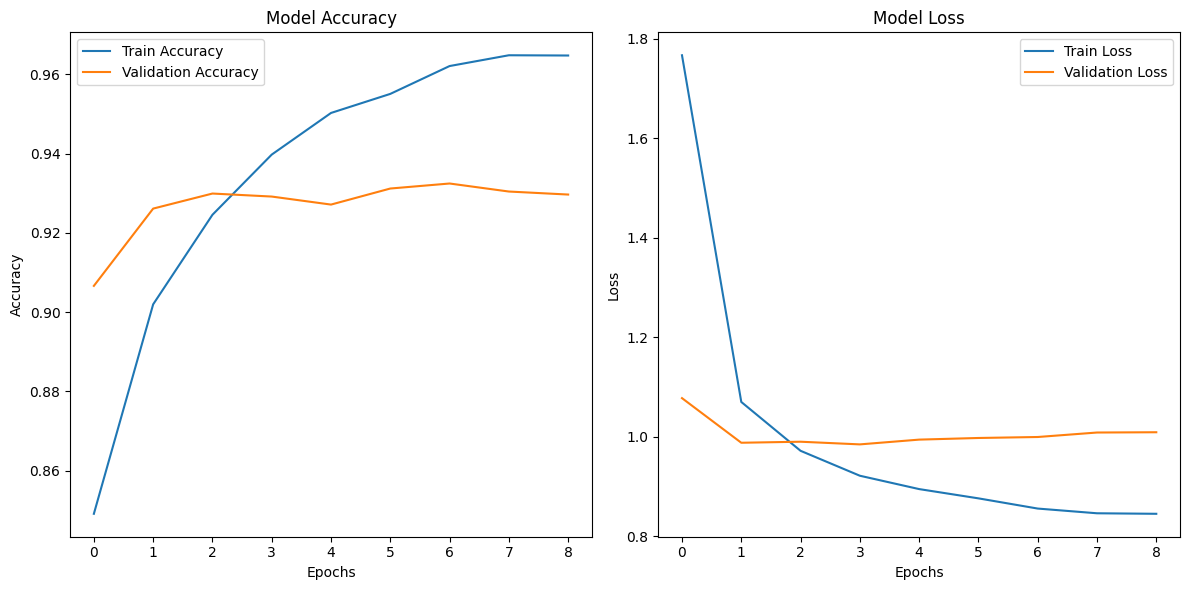

In [13]:
import matplotlib.pyplot as plt

# Extract the training history
history = history.history

# Plot training & validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
final_train_acc = history['accuracy'][-1]
final_val_acc = history['val_accuracy'][-1]
final_train_loss = history['loss'][-1]
final_val_loss = history['val_loss'][-1]

print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")

Final Training Accuracy: 0.9647
Final Validation Accuracy: 0.9297
Final Training Loss: 0.8449
Final Validation Loss: 1.0088


In [15]:
if 'lr' in history:  # Remove .history as 'history' is already a dictionary
    plt.plot(history['lr'], label='Learning Rate')
    plt.title('Learning Rate Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.show()

In [16]:
print(f"Training stopped at epoch: {len(history['loss'])}")

Training stopped at epoch: 9


# **History Saving**

In [19]:
import json
import os  # Import the os module

# Create directories if they don't exist
os.makedirs("/content/drive/MyDrive/Final_DL_Project/Vgg16_waste", exist_ok=True)

# Save history to a JSON file on Google Drive
with open("'/content/drive/MyDrive/Final_DL_Project/training_history.json", "w") as f:
    json.dump(history, f)  # Use 'history' instead of 'History.history'

# Load the history later
with open("/content/drive/MyDrive/Final_DL_Project/training_history.json", "r") as f:
    loaded_history = json.load(f)
    print(loaded_history)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Final_DL_Project/training_history.json'

# **Model Evaluation Using Test Data**

In [20]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
import numpy as np
import tensorflow as tf
checkpoint_path = '/content/drive/MyDrive/Final_DL_Project/Waste_vgg16_best_model.keras'
model = tf.keras.models.load_model(checkpoint_path)

test_generator.reset()
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)

# Convert predictions to binary labels
predicted_labels = np.where(predictions > 0.5, 1, 0).flatten()

# Get the true labels
true_labels = test_generator.classes

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:\n", conf_matrix)

# Classification Report
class_report = classification_report(true_labels, predicted_labels, target_names=['Healthy', 'Rotten'])
print("\nClassification Report:\n", class_report)

# Accuracy Score
accuracy = accuracy_score(true_labels, predicted_labels)
print("\nAccuracy:", accuracy)

# F1 Score
f1 = f1_score(true_labels, predicted_labels)
print("\nF1 Score:", f1)


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


155/155 ━━━━━━━━━━━━━━━━━━━━ 36s 229ms/step
Confusion Matrix:
 [[2600  159]
 [ 159 2023]]

Classification Report:
               precision    recall  f1-score   support

     Healthy       0.94      0.94      0.94      2759
      Rotten       0.93      0.93      0.93      2182

    accuracy                           0.94      4941
   macro avg       0.93      0.93      0.93      4941
weighted avg       0.94      0.94      0.94      4941


Accuracy: 0.9356405585913783

F1 Score: 0.9271310724106324


In [21]:
# Define where to save everything
results_save_path = "/content/drive/MyDrive/Final_DL_Project/waste_vgg16_results.txt"
conf_matrix_save_path = "/content/drive/MyDrive/Final_DL_Project/waste_vgg16_confusion_matrix.png"
with open(results_save_path, "w") as file:
    file.write(f"Accuracy: {accuracy:.4f}\n")
    file.write(f"F1 Score: {f1:.4f}\n")
    file.write(f"classification Report:\n {class_report}\n")
    file.write(f"Confusion Matrix:\n{conf_matrix}\n")

print(f"Results saved to {results_save_path}")

Results saved to /content/drive/MyDrive/Final_DL_Project/waste_vgg16_results.txt


In [22]:
import matplotlib.pyplot as plt  # Import the plotting library and assign it to the alias 'plt'
import seaborn as sns
# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Healthy", "Rotten"], yticklabels=["Healthy", "Rotten"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Save confusion matrix as an image
plt.savefig(conf_matrix_save_path)
print(f"Confusion matrix saved to {conf_matrix_save_path}")
from IPython.display import Image
Image(filename=conf_matrix_save_path)
plt.close()  # Close the plot to free up memory

Confusion matrix saved to /content/drive/MyDrive/Final_DL_Project/waste_vgg16_confusion_matrix.png


# **GUI**
